In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import njit, prange
from os import listdir
from os.path import isfile, join

%matplotlib inline
plt.style.use(['science','ieee'])

# IMPORT THE TRAINING DATA

In [2]:
for i in range(0,24):
    if i < 12:
        df = pd.read_csv('../data/training_data/' + str(i) + '.csv')
    else:
        df = pd.read_csv('../data/training_data/s' + str(i-12) + '.csv')
    throttle = df.throttle
    brake = df.brake
    exec("t{} = np.array(df.t).astype('float64')".format(i))
    exec("u{} = np.array([throttle, brake]).T.astype('float64')".format(i))
    exec("v{} = np.array(df.v).astype('float64')".format(i))

# MAKE FUNCTION

## Generate population

In [3]:
def generate_population(num, dim, rng):
    """
    Generate flowers:
        Input:
            num: number of flowers (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            flws: initial position of the flowers (numpy array)
    """
    flws = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        flws[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return flws

## Constraint

In [4]:
ndim = 17
@njit
def admissible(param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    if a1 > 0. or a2 > 0. or a3 > 0. or b1 < 0. or b2 < 0. or c1 > 0. or c2 > 0. or np.around(td11)<0 or np.around(td12)<0 or np.around(td13)<0 or np.around(td21)<0 or np.around(td22)<0 or np.around(td23)<0:
        return False
    else:
        return True
    
_ = admissible(np.random.randn(ndim))

## Forward propagation

In [5]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut
_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2]), 0)

In [6]:
@njit
def forward_propagation(t, u, param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    td11 = int(np.around(td11))
    td12 = int(np.around(td12))
    td13 = int(np.around(td13))
    td21 = int(np.around(td21))
    td22 = int(np.around(td22))
    td23 = int(np.around(td23))

    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0.0
    for i in range(t.shape[0]):
        if i == 0:
            dt = t[1] - t[0]
        else:
            dt = t[i] - t[i-1]
            
        u1, u2 = u[i]        
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 \
                + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t \
                + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out
_ = forward_propagation(np.arange(10, dtype=float), np.random.randn(10,2), np.ones(ndim))

## Cost and metric

In [7]:
@njit
def cost(t, u, v, param):
    error = (v - forward_propagation(t, u, param))
    cost = np.dot(error.T, error)
    return cost
_ = cost(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def accuracy(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    numerator = np.linalg.norm(error)
    denumerator = np.linalg.norm(v - np.mean(v))
    acc = 1.0 - numerator / denumerator
    return acc
_ = accuracy(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def mean_absolute_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.mean(np.abs(error))
    return out
_ = mean_absolute_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def mean_squared_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.mean(error**2)
    return out
_ = mean_squared_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def maximum_absolute_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.max(np.abs(error))
    return out
_ = maximum_absolute_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

In [8]:
for i in range(0,24):
    if i < 12:
        df = pd.read_csv('../data/training_data/' + str(i) + '.csv')
    else:
        df = pd.read_csv('../data/training_data/s' + str(i-12) + '.csv')
    throttle = df.throttle
    brake = df.brake
    exec("t{} = np.array(df.t).astype('float64')".format(i))
    exec("u{} = np.array([throttle, brake]).T.astype('float64')".format(i))
    exec("v{} = np.array(df.v).astype('float64')".format(i))

In [9]:
gain = np.array([1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0])

@njit
def calculate_total_cost(param):
    loss = np.Inf
    if admissible(param):
        loss = 0.
        m = 0.
        
        loss += cost(t0, u0, v0, param) * gain[0]
        loss += cost(t1, u1, v1, param) * gain[1]
        loss += cost(t2, u2, v2, param) * gain[2]
        loss += cost(t3, u3, v3, param) * gain[3]
        loss += cost(t4, u4, v4, param) * gain[4]
        loss += cost(t5, u5, v5, param) * gain[5]
        loss += cost(t6, u6, v6, param) * gain[6]
        loss += cost(t7, u7, v7, param) * gain[7]
        loss += cost(t8, u8, v8, param) * gain[8]
        loss += cost(t9, u9, v9, param) * gain[9]
        loss += cost(t10, u10, v10, param) * gain[10]
        loss += cost(t11, u11, v11, param) * gain[11]
        loss += cost(t12, u12, v12, param) * gain[12]
        loss += cost(t13, u13, v13, param) * gain[13]
        loss += cost(t14, u14, v14, param) * gain[14]
        loss += cost(t15, u15, v15, param) * gain[15]
        loss += cost(t16, u16, v16, param) * gain[16]
        loss += cost(t17, u17, v17, param) * gain[17]
        loss += cost(t18, u18, v18, param) * gain[18]
        loss += cost(t19, u19, v19, param) * gain[19]
        loss += cost(t20, u20, v20, param) * gain[20]
        loss += cost(t21, u21, v21, param) * gain[21]
        loss += cost(t22, u22, v22, param) * gain[22]
        loss += cost(t23, u23, v23, param) * gain[23]

        m += t0.shape[0] * gain[0]
        m += t1.shape[0] * gain[1]
        m += t2.shape[0] * gain[2]
        m += t3.shape[0] * gain[3]
        m += t4.shape[0] * gain[4]
        m += t5.shape[0] * gain[5]
        m += t6.shape[0] * gain[6]
        m += t7.shape[0] * gain[7]
        m += t8.shape[0] * gain[8]
        m += t9.shape[0] * gain[9]
        m += t10.shape[0] * gain[10]
        m += t11.shape[0] * gain[11]
        m += t12.shape[0] * gain[12]
        m += t13.shape[0] * gain[13]
        m += t14.shape[0] * gain[14]
        m += t15.shape[0] * gain[15]
        m += t16.shape[0] * gain[16]
        m += t17.shape[0] * gain[17]
        m += t18.shape[0] * gain[18]
        m += t19.shape[0] * gain[19]
        m += t20.shape[0] * gain[20]
        m += t21.shape[0] * gain[21]
        m += t22.shape[0] * gain[22]
        m += t23.shape[0] * gain[23]

        loss = loss / m
        
    return loss
_ = calculate_total_cost(np.ones(ndim))

In [10]:
@njit
def flowers_cost(flowers):
    length = flowers.shape[0]
    losses = np.empty(length)
    for ii in range(length):
        losses[ii] = calculate_total_cost(flowers[ii])
    return losses
_ = flowers_cost(np.ones((2,ndim)))

## Pollination

In [11]:
@njit
def fpa(flowers, loss_flowers, global_, global_loss_, p, alpha, gamma, var, s0):
    num = flowers.shape[0]
    dim = flowers.shape[1]    
    out = np.empty(flowers.shape)
    temp = np.empty(dim)
    loss = np.empty(loss_flowers.shape)
    temp_loss = 0.
    random_number = np.random.uniform(0., 1., num)
    for i in range(num):
        # GLOBAL POLLINATION
        if random_number[i] < p:
            # Generate Levy Flight
            upper = np.random.normal(0., np.sqrt(var), size=dim)
            lower = np.abs(np.random.normal(0., 1., size=dim))**(1./alpha)
            L = np.divide(upper, lower)
            
            for j in range(L.shape[0]):
                if L[j] < s0:
                    L[j] = s0
            
            temp = flowers[i] + gamma * L * (global_ - flowers[i])
        # LOCAL POLLINATION
        else:
            while(True):
                i1, i2 = np.random.randint(0, num, size=2)
                if i1==i2 or i1==i or i2==i:
                    if num <= 5: # For breaking the loop
                        None
                    else:
                        continue
                break
            epsilon = np.random.uniform(0.,1.)
            
            temp = flowers[i] + epsilon * (flowers[i1] - flowers[i2])
        
        # CALCULATE COST
        temp_loss = calculate_total_cost(temp)
        if np.isnan(temp_loss):
            temp_loss = np.Inf
        
        # UPDATE
        if temp_loss < loss_flowers[i]:
            out[i] = temp
            loss[i] = temp_loss
        else:
            out[i] = flowers[i]
            loss[i] = loss_flowers[i]
    
    min_idx = np.argmin(loss)
    min_loss = loss[min_idx]
    if global_loss_ > min_loss:
        global_loss_new = min_loss
        global_new = out[min_idx, :]
    else:
        global_new = global_
        global_loss_new = global_loss_
    
    return out, loss, global_new, global_loss_new

xx1 = np.ones((2, ndim))
xx2 = np.ones(2)
xx3 = np.random.randn(ndim)
_ = fpa(xx1, xx2, xx3, 100.0, 0.8, 1.5, 0.1, 0.69, 0.1)

# SIMULATION (OPTIMIZATION)

In [12]:
num = 50
n_sim = 20
n_itr = 10000

r_a1 = [0., -2.]
r_a2 = [0., -2.]
r_a3 = [0., -2.]
r_b1 = [0., 2.]
r_b2 = [0., 2.]
r_b3 = [-2., 2.]
r_b4 = [-2., 2.]
r_c1 = [0., -2.]
r_c2 = [0., -2.]
r_c3 = [-2., 2.]
r_c4 = [-2., 2.]
r_td11 = [0, 15]
r_td12 = [0, 15]
r_td13 = [0, 15]
r_td21 = [0, 6]
r_td22 = [0, 6]
r_td23 = [0, 6]
rng = [r_a1, r_a2, r_a3,
       r_b1, r_b2, r_b3, r_b4,
       r_c1, r_c2, r_c3, r_c4,
       r_td11, r_td12, r_td13,
       r_td21, r_td22, r_td23
      ]
dim = len(rng)

s0 = 0.1
p_threshold = 0.8
alpha = 1.5
gamma = 0.1
var = (math.gamma(1+alpha)/alpha/math.gamma((1+alpha)/2) * np.sin(np.pi * alpha/2)/2**((alpha-1)/2))**(1/alpha)

In [13]:
param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim) * np.Inf

the_best_param_history = np.zeros((n_itr, dim))
the_best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    flowers = generate_population(num, dim, rng)
    global_ = None
    global_loss_ = np.Inf

    loss_flowers = flowers_cost(flowers)
    loss_flowers[np.isnan(loss_flowers)] = np.Inf
    min_idx = np.argmin(loss_flowers)
    min_loss = loss_flowers[min_idx]
    if global_loss_ > min_loss:
        global_loss_ = min_loss
        global_ = flowers[min_idx, :]

    # Limiting Levy Flight s0 = 0.1
    global_history = np.empty((n_itr, dim))
    global_history[0] = global_
    global_loss_history = np.empty(n_itr)
    global_loss_history[0] = global_loss_
    for i in range(1, n_itr):
        # Flower Pollination Algorithm
        flowers, loss_flowers, global_, global_loss_ = fpa(flowers, loss_flowers, global_, global_loss_, p_threshold, alpha, gamma, var, s0)
        
        if (i-1) % 500 == 0:
            print('simulation: {} || iteration: {} || global_loss: {:.5f}'.format(j+1, i, global_loss_))

        global_history[i] = global_
        global_loss_history[i] = global_loss_
    
    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || the best loss: {:.10f}'.format(j, the_best_loss_history[-1]))

simulation: 1 || iteration: 1 || global_loss: 104.52055
simulation: 1 || iteration: 501 || global_loss: 0.33253
simulation: 1 || iteration: 1001 || global_loss: 0.13066
simulation: 1 || iteration: 1501 || global_loss: 0.08643
simulation: 1 || iteration: 2001 || global_loss: 0.07288
simulation: 1 || iteration: 2501 || global_loss: 0.06884
simulation: 1 || iteration: 3001 || global_loss: 0.06752
simulation: 1 || iteration: 3501 || global_loss: 0.06708
simulation: 1 || iteration: 4001 || global_loss: 0.06693
simulation: 1 || iteration: 4501 || global_loss: 0.06686
simulation: 1 || iteration: 5001 || global_loss: 0.06683
simulation: 1 || iteration: 5501 || global_loss: 0.06681
simulation: 1 || iteration: 6001 || global_loss: 0.06678
simulation: 1 || iteration: 6501 || global_loss: 0.06677
simulation: 1 || iteration: 7001 || global_loss: 0.06676
simulation: 1 || iteration: 7501 || global_loss: 0.06675
simulation: 1 || iteration: 8001 || global_loss: 0.06674
simulation: 1 || iteration: 8501 

In [14]:
# Save the simulation
np.save('result/param_history.npy', param_history)
np.save('result/loss_history.npy', loss_history)
np.save('result/the_best_loss_history.npy', the_best_loss_history)
np.save('result/the_best_param_history.npy', the_best_param_history)

In [15]:
f = open("result/sim.cfg", "w+")
f.writelines('num: {} # The number of flowers\n'.format(num))
f.writelines('n_sim: {} # The number of simulation loop\n'.format(n_sim))
f.writelines('n_itr: {} # The number of iteration for each simulation\n'.format(n_itr))
f.writelines('\n# The boundary of the initialization value\n')
f.writelines('\tr_a1: {}\n'.format(r_a1))
f.writelines('\tr_a2: {}\n'.format(r_a2))
f.writelines('\tr_a3: {}\n'.format(r_a3))
f.writelines('\tr_b1: {}\n'.format(r_b1))
f.writelines('\tr_b2: {}\n'.format(r_b2))
f.writelines('\tr_b3: {}\n'.format(r_b3))
f.writelines('\tr_b4: {}\n'.format(r_b4))
f.writelines('\tr_c1: {}\n'.format(r_c1))
f.writelines('\tr_c2: {}\n'.format(r_c2))
f.writelines('\tr_c3: {}\n'.format(r_c3))
f.writelines('\tr_c4: {}\n'.format(r_c4))
f.writelines('\tr_td11: {}\n'.format(r_td11))
f.writelines('\tr_td12: {}\n'.format(r_td12))
f.writelines('\tr_td13: {}\n'.format(r_td13))
f.writelines('\tr_td21: {}\n'.format(r_td21))
f.writelines('\tr_td22: {}\n'.format(r_td22))
f.writelines('\tr_td23: {}\n'.format(r_td23))
f.writelines('\n# The gain of the dataset\n')
for i in range(gain.shape[0]):
    f.writelines('\tdata-{}: {}\n'.format(i, gain[i]))
f.writelines('\n# The FPA hyperparameters\n')
f.writelines('\ts0: {}\n'.format(s0))
f.writelines('\tp_threshold: {}\n'.format(p_threshold))
f.writelines('\talpha: {}\n'.format(alpha))
f.writelines('\tgamma: {}\n'.format(gamma))
f.writelines('\tvar: {}\n'.format(var))
f.close()

# RESULT

## Load Model

In [16]:
# Load the model
the_best_param_history = np.load('result/the_best_param_history.npy')
the_best_loss_history = np.load('result/the_best_loss_history.npy')
global_ = the_best_param_history[-1]
global_loss_ = the_best_loss_history[-1]

In [17]:
param_name = ['a1', 'a2', 'a3', 'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4', 'd11', 'd12', 'd13', 'd21', 'd22', 'd23']
print('The minimum loss: {}'.format(global_loss_))
print('Parameters:')
for i in range(len(param_name)):
    print('{}: {}'.format(param_name[i], global_[i]))

The minimum loss: 0.06562772025367979
Parameters:
a1: -0.05083572491866108
a2: -0.5860082096307972
a3: -1.0460007700065875e-15
b1: 3.3864685052820904e-12
b2: 2.8068748613806713
b3: 0.03451565930327695
b4: 0.9399485778763016
c1: -5.388897671624161
c2: -44.14082687533428
c3: -0.06291213949714064
c4: -5.261979901978945
d11: 0.4795419586068174
d12: 15.65152537784066
d13: 3.8316713154377195
d21: 23.444771961624127
d22: 1.4462183786262122
d23: 0.9202719671727073


## Visualization

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


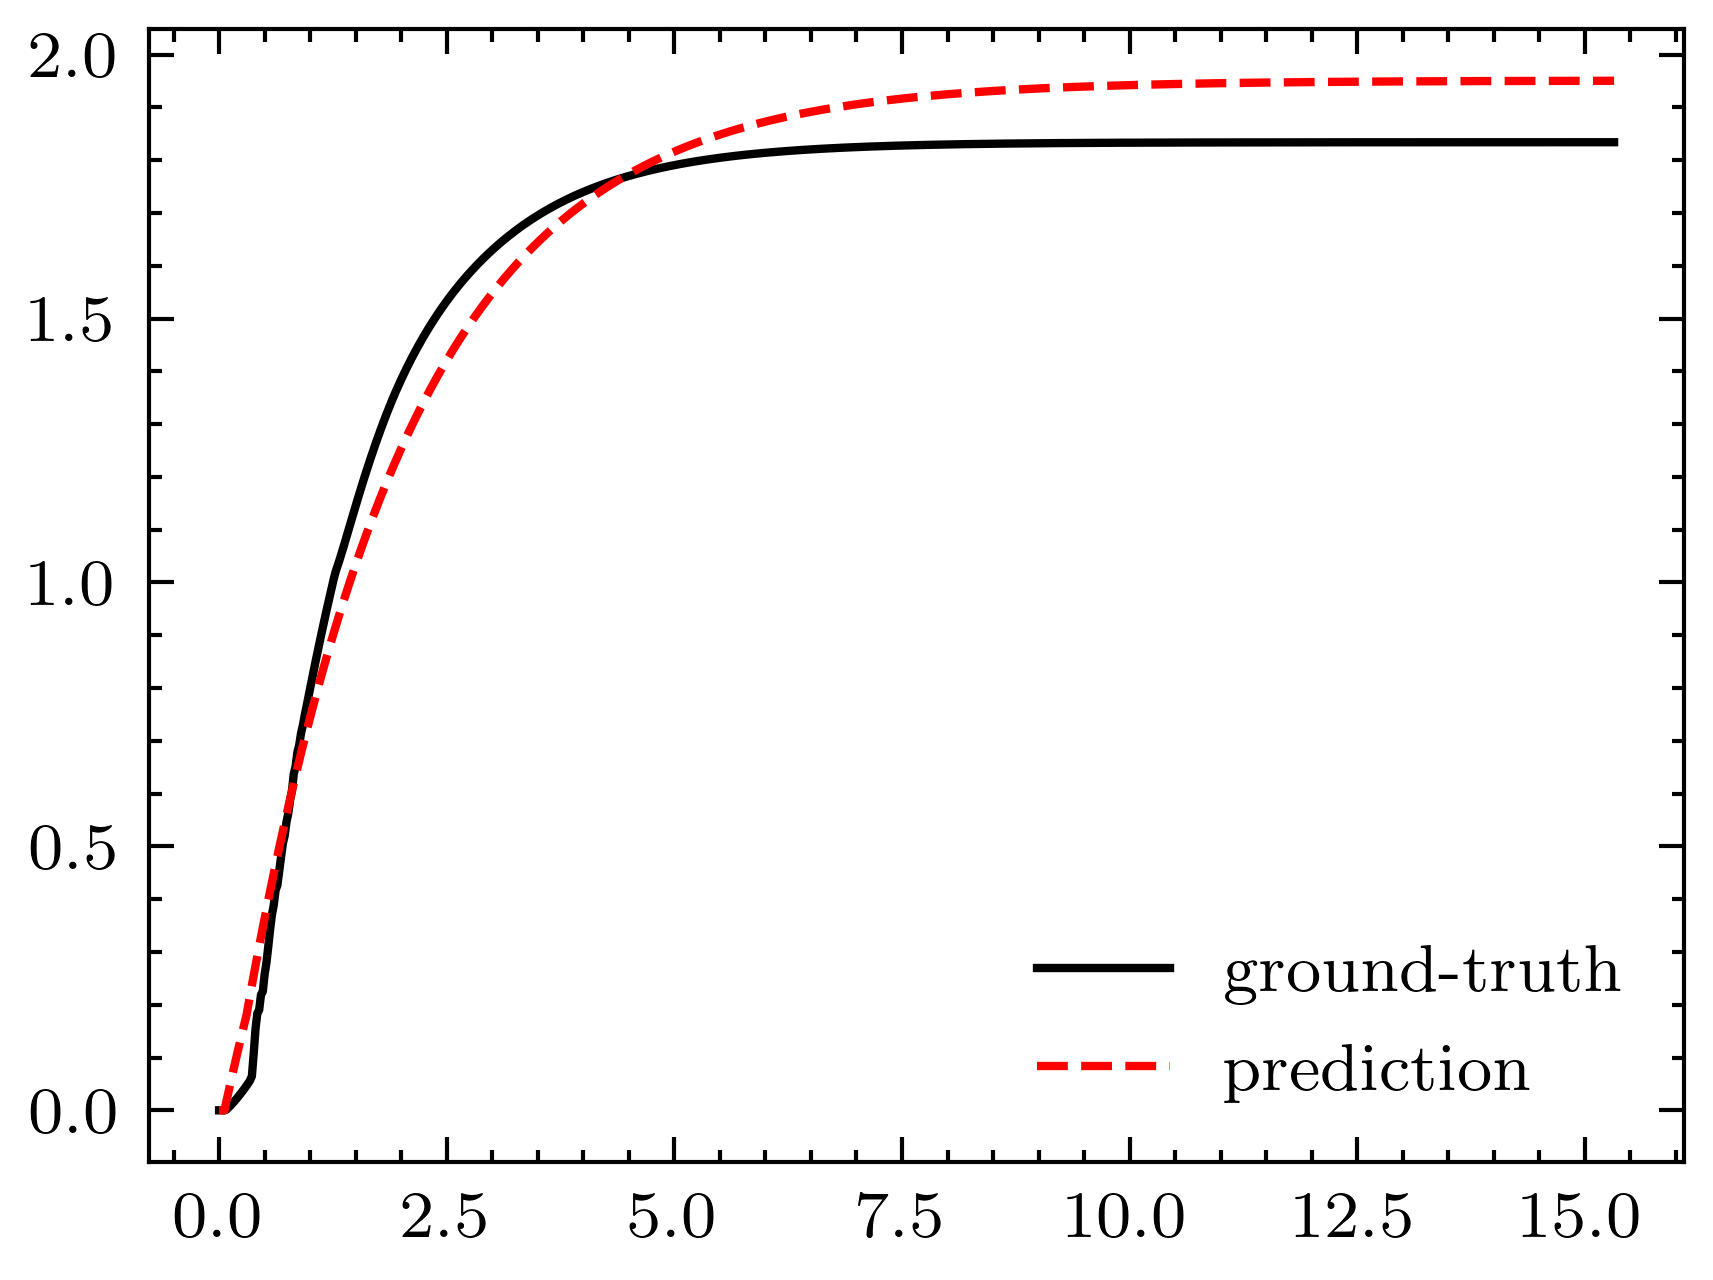

In [18]:
# Visualization
idx = 12
exec("t = np.copy(t{})".format(idx))
exec("u = np.copy(u{})".format(idx))
exec("v = np.copy(v{})".format(idx))
test = forward_propagation(t, u, global_)
plt.plot(t, v, label='ground-truth')
plt.plot(t, test, label='prediction')
plt.legend()
plt.show()

## Cost and Metrics

In [19]:
acc = []
mse = []
maae = [] 
for i in range(24):
    exec("acc.append(accuracy(t{}, u{}, v{}, global_))".format(i, i, i))
    exec("mse.append(mean_squared_error(t{}, u{}, v{}, global_))".format(i, i, i))
    exec("maae.append(maximum_absolute_error(t{}, u{}, v{}, global_))".format(i, i, i))

In [20]:
print('Accuracy')
for i in range(24):
    print('Data ke-{}: {:.2f}%'.format(i+1, acc[i]*100))

Accuracy
Data ke-1: 90.41%
Data ke-2: 93.42%
Data ke-3: 94.89%
Data ke-4: 89.84%
Data ke-5: 87.88%
Data ke-6: 94.75%
Data ke-7: 96.04%
Data ke-8: 85.61%
Data ke-9: 77.48%
Data ke-10: 90.56%
Data ke-11: 95.36%
Data ke-12: 95.85%
Data ke-13: 76.66%
Data ke-14: 86.19%
Data ke-15: 77.77%
Data ke-16: 84.36%
Data ke-17: 91.55%
Data ke-18: 91.73%
Data ke-19: 83.79%
Data ke-20: 90.45%
Data ke-21: 96.70%
Data ke-22: 91.70%
Data ke-23: 88.83%
Data ke-24: 92.87%


In [21]:
print('Mean Squared Error')
for i in range(24):
    print('Data ke-{}: {:.5f}'.format(i+1, mse[i]))

Mean Squared Error
Data ke-1: 0.01038
Data ke-2: 0.05204
Data ke-3: 0.05826
Data ke-4: 0.03428
Data ke-5: 0.10854
Data ke-6: 0.07229
Data ke-7: 0.04910
Data ke-8: 0.08238
Data ke-9: 0.03860
Data ke-10: 0.03079
Data ke-11: 0.02325
Data ke-12: 0.03503
Data ke-13: 0.00912
Data ke-14: 0.00710
Data ke-15: 0.04656
Data ke-16: 0.04172
Data ke-17: 0.02182
Data ke-18: 0.02964
Data ke-19: 0.13598
Data ke-20: 0.05012
Data ke-21: 0.01068
Data ke-22: 0.08229
Data ke-23: 0.19803
Data ke-24: 0.13750


In [22]:
print('Maximum Absolute Squared Error')
for i in range(24):
    print('Data ke-{}: {:.3f}'.format(i+1, maae[i]))

Maximum Absolute Squared Error
Data ke-1: 0.494
Data ke-2: 0.949
Data ke-3: 0.693
Data ke-4: 0.345
Data ke-5: 0.819
Data ke-6: 1.009
Data ke-7: 1.038
Data ke-8: 0.700
Data ke-9: 0.253
Data ke-10: 0.432
Data ke-11: 0.765
Data ke-12: 1.036
Data ke-13: 0.172
Data ke-14: 0.226
Data ke-15: 0.337
Data ke-16: 0.425
Data ke-17: 0.355
Data ke-18: 0.259
Data ke-19: 0.455
Data ke-20: 0.270
Data ke-21: 0.229
Data ke-22: 0.344
Data ke-23: 0.511
Data ke-24: 0.696


In [23]:
num = 0
for i in range(24):
    exec("num += t{}.shape[0]".format(i))
vv = np.empty(num)
vv_gt = np.empty(num)
nn = 0
for i in range(24):
    exec("n = t{}.shape[0]".format(i))
    exec("vv[nn: nn+n] = forward_propagation(t{}, u{}, global_)".format(i, i))
    exec("vv_gt[nn: nn+n] = v{}".format(i))
    nn += n
total_accuracy = (1 - np.linalg.norm(vv_gt - vv)/np.linalg.norm(vv_gt - np.mean(vv_gt)))
print('Total Accuracy: {:.2f}%'.format(total_accuracy*100))

Total Accuracy: 96.05%
